In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2016 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Point Interpolation

Compares different point interpolation approaches.

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np

from metpy.cbook import get_test_data
from metpy.interpolate import (interpolate_to_grid, remove_nan_observations,
                               remove_repeat_coordinates)
from metpy.plots import add_metpy_logo


In [4]:
def basic_map(proj, title):
    """Make our basic default map for plotting"""
    fig = plt.figure(figsize=(15, 10))
    add_metpy_logo(fig, 0, 80, size='large')
    view = fig.add_axes([0, 0, 1, 1], projection=proj)
    view.set_title(title)
    view.set_extent([-120, -70, 20, 50])
    view.add_feature(cfeature.STATES.with_scale('50m'))
    view.add_feature(cfeature.OCEAN)
    view.add_feature(cfeature.COASTLINE)
    view.add_feature(cfeature.BORDERS, linestyle=':')
    return fig, view


def station_test_data(variable_names, proj_from=None, proj_to=None):
    with get_test_data('station_data.txt') as f:
        all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                              usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                              dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                              ('slp', 'f'), ('air_temperature', 'f'),
                                              ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                              ('weather', '16S'),
                                              ('wind_dir', 'f'), ('wind_speed', 'f')]))

    all_stids = [s.decode('ascii') for s in all_data['stid']]

    data = np.concatenate([all_data[all_stids.index(site)].reshape(1, ) for site in all_stids])

    value = data[variable_names]
    lon = data['lon']
    lat = data['lat']

    if proj_from is not None and proj_to is not None:
        proj_points = proj_to.transform_points(proj_from, lon, lat)
        return proj_points[:, 0], proj_points[:, 1], value

    return lon, lat, value


from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

levels = list(range(-20, 20, 1))
cmap = plt.get_cmap('magma')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

x, y, temp = station_test_data('air_temperature', from_proj, to_proj)

x, y, temp = remove_nan_observations(x, y, temp)
x, y, temp = remove_repeat_coordinates(x, y, temp)

# Scipy.interpolate linear

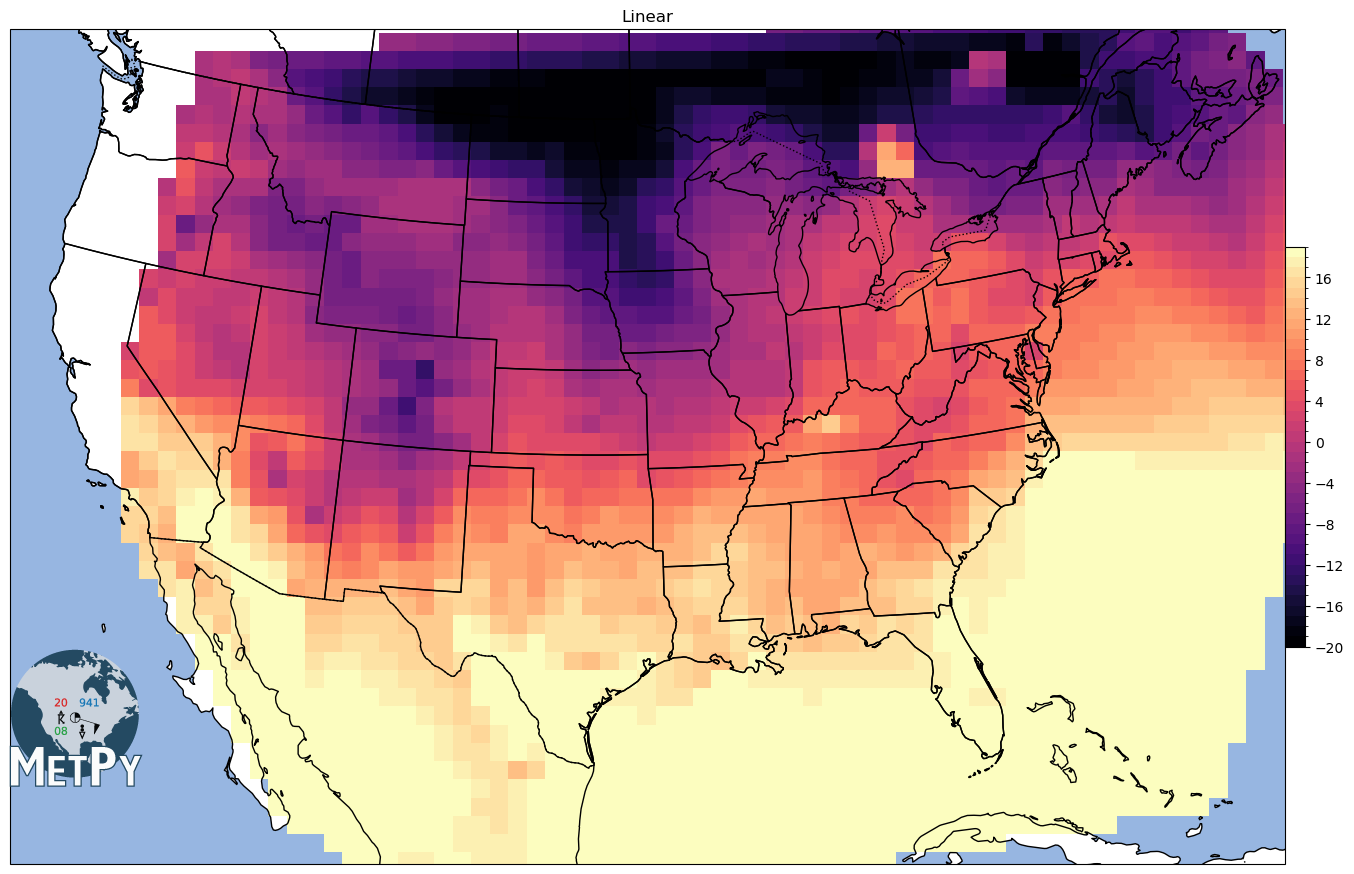

In [5]:
gx, gy, img = interpolate_to_grid(x, y, temp, interp_type='linear', hres=75000)
img = np.ma.masked_where(np.isnan(img), img)
fig, view = basic_map(to_proj, 'Linear')
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Natural neighbor interpolation (MetPy implementation)
[Reference](https://cwp.mines.edu/wp-content/uploads/sites/112/2018/09/cwp-657.pdf)

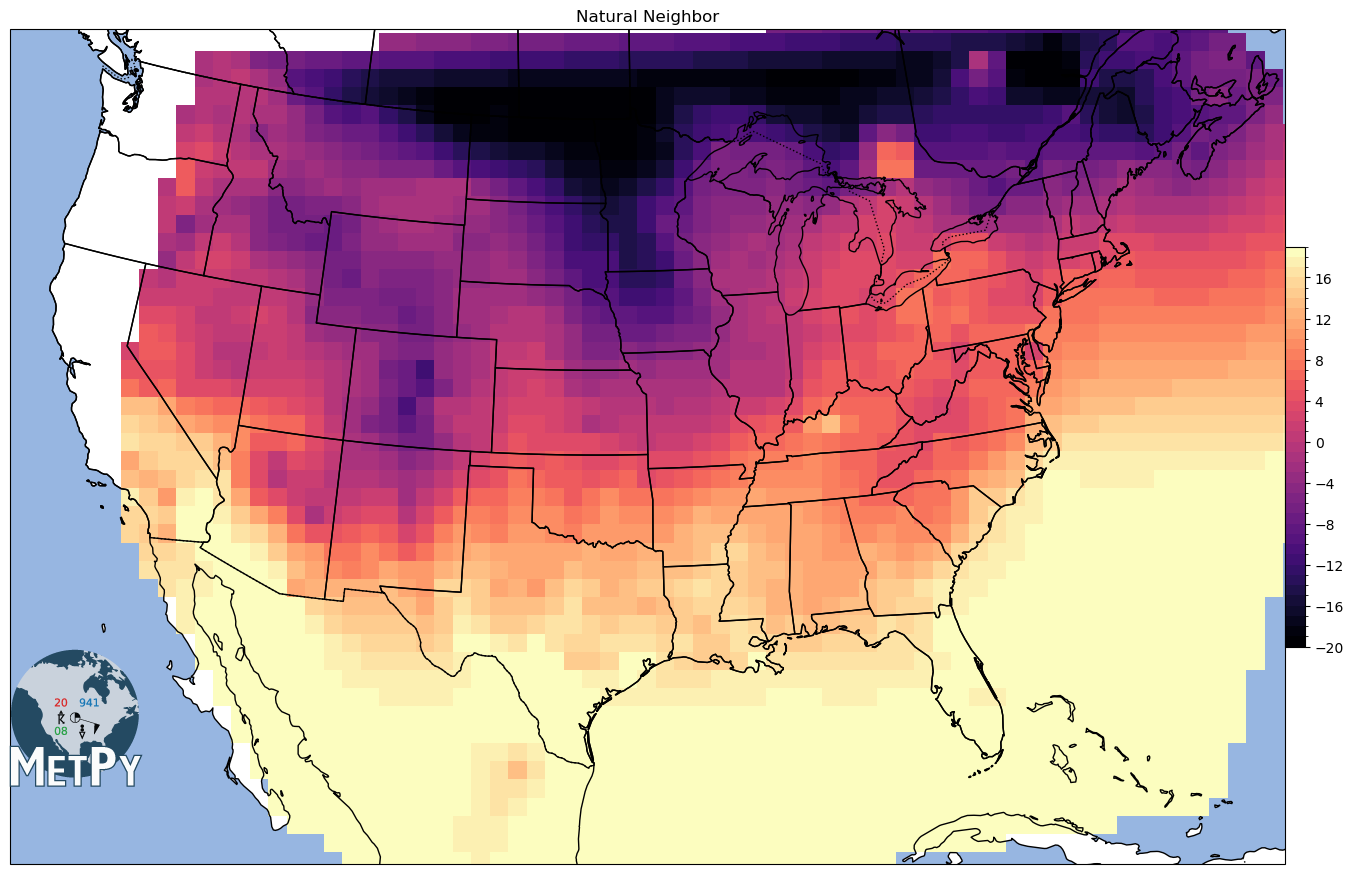

In [6]:
gx, gy, img = interpolate_to_grid(x, y, temp, interp_type='natural_neighbor', hres=75000)
img = np.ma.masked_where(np.isnan(img), img)
fig, view = basic_map(to_proj, 'Natural Neighbor')
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Cressman interpolation
search_radius = 100 km

grid resolution = 75 km

min_neighbors = 1

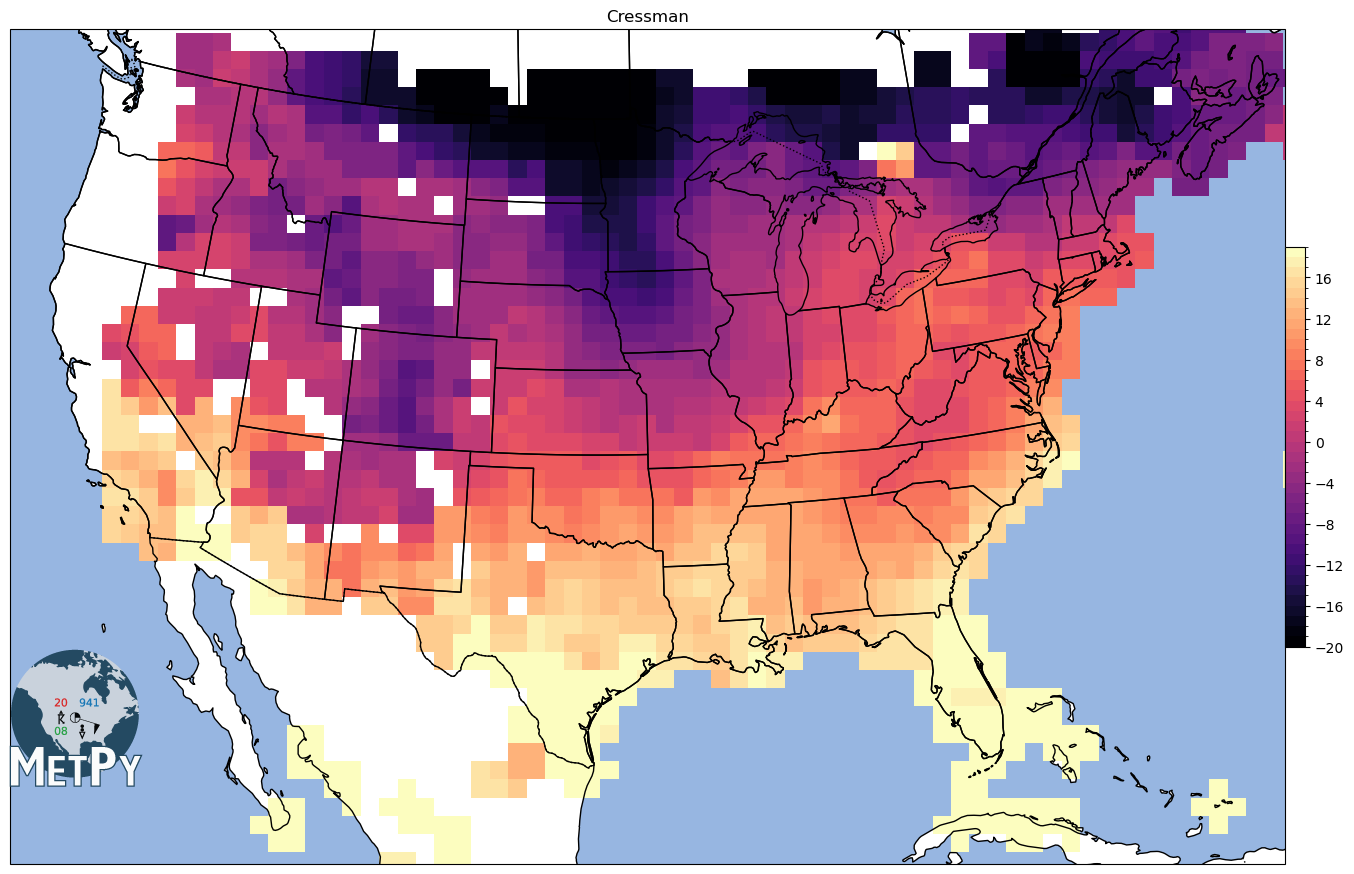

In [7]:
gx, gy, img = interpolate_to_grid(x, y, temp, interp_type='cressman', minimum_neighbors=1,
                                  hres=75000, search_radius=100000)
img = np.ma.masked_where(np.isnan(img), img)
fig, view = basic_map(to_proj, 'Cressman')
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Barnes Interpolation
search_radius = 100km

min_neighbors = 3

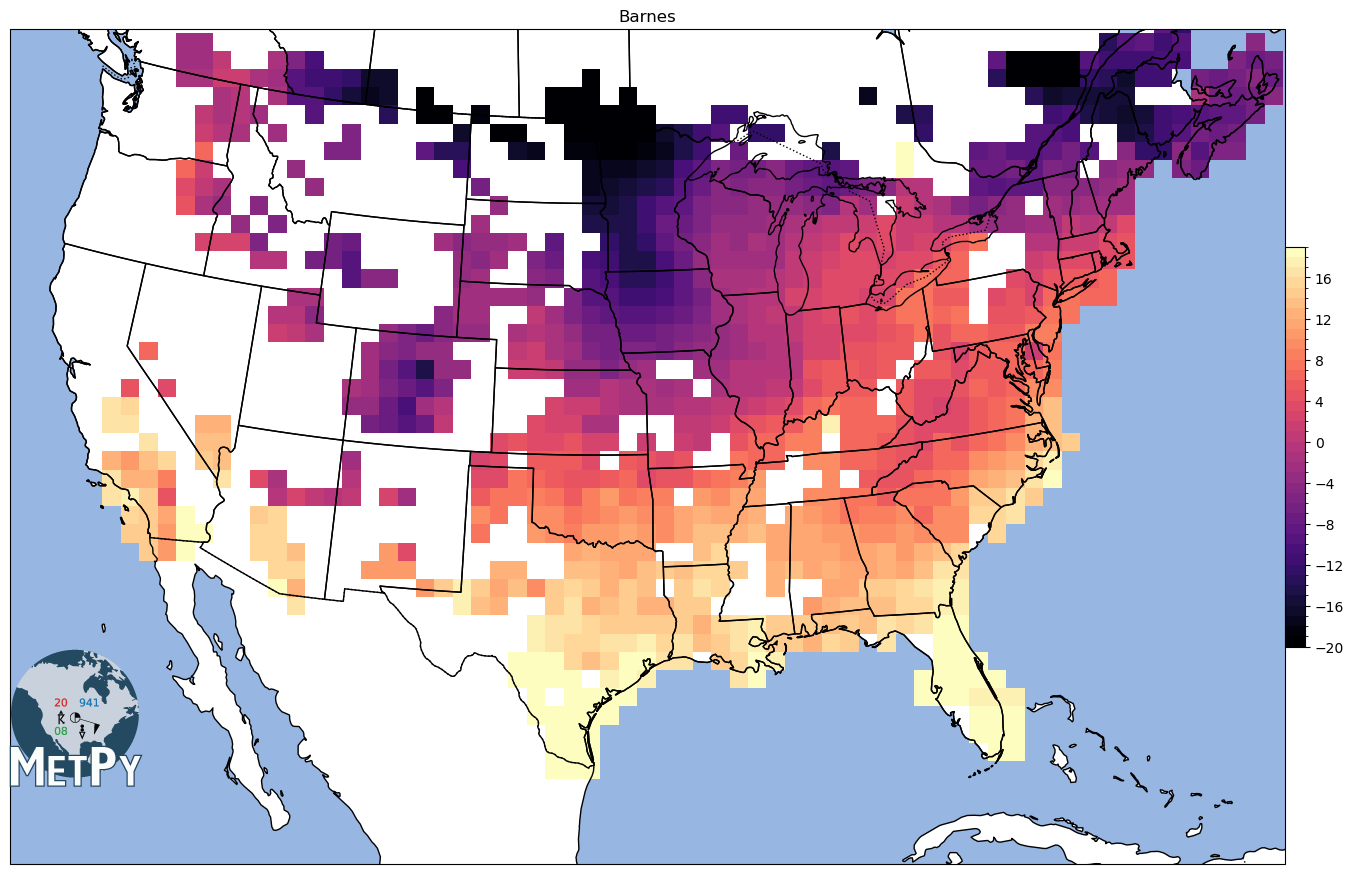

In [8]:
gx, gy, img1 = interpolate_to_grid(x, y, temp, interp_type='barnes', hres=75000,
                                   search_radius=100000)
img1 = np.ma.masked_where(np.isnan(img1), img1)
fig, view = basic_map(to_proj, 'Barnes')
mmb = view.pcolormesh(gx, gy, img1, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Radial basis function interpolation
linear

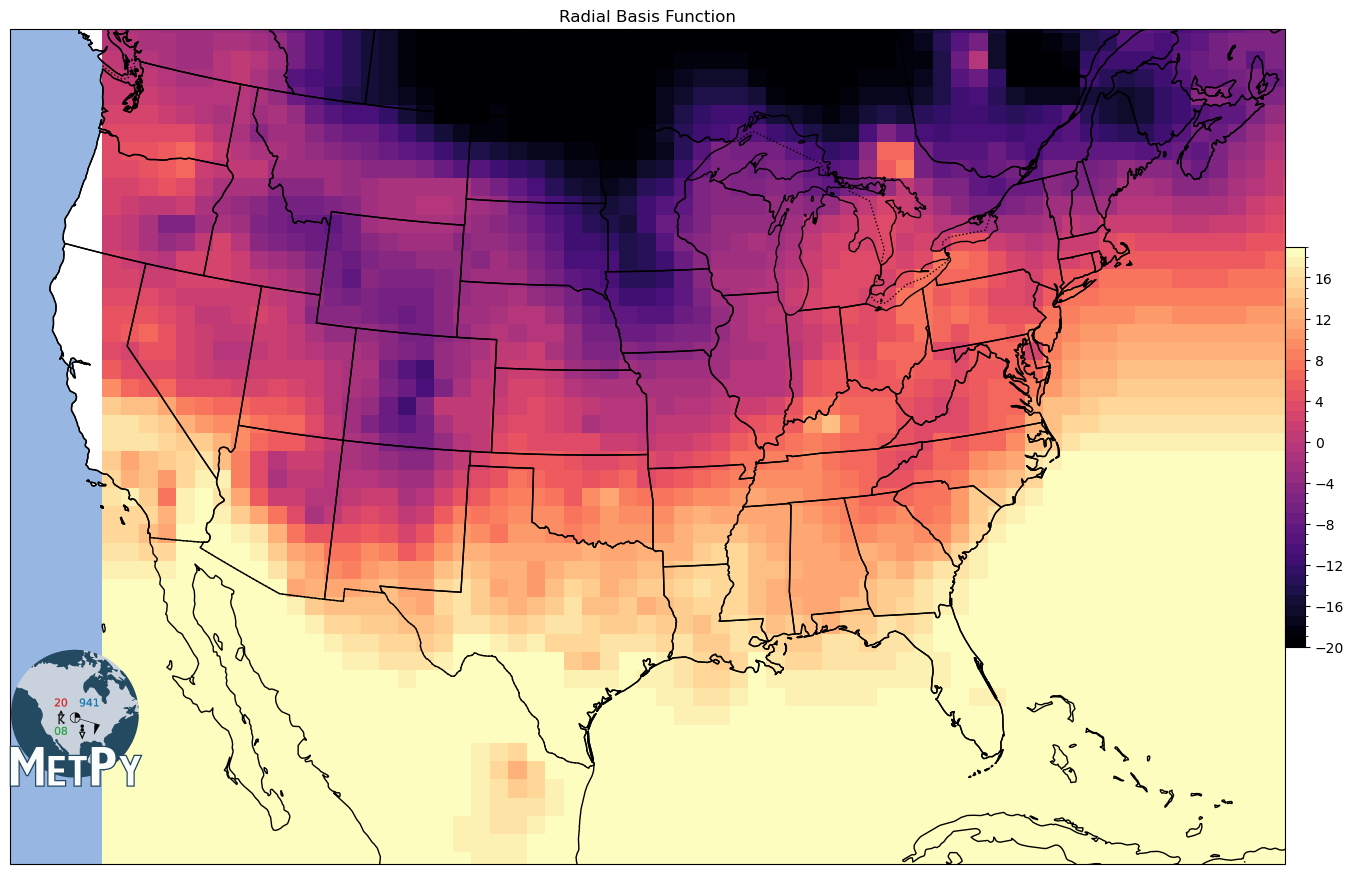

In [9]:
gx, gy, img = interpolate_to_grid(x, y, temp, interp_type='rbf', hres=75000, rbf_func='linear',
                                  rbf_smooth=0)
img = np.ma.masked_where(np.isnan(img), img)
fig, view = basic_map(to_proj, 'Radial Basis Function')
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

plt.show()